In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import yaml
import glob
import plot_helper
from datasets import get_dataset, get_2d_samples
import utils
from nets import load_model
from losses import compute_acc

import perturbation

In [14]:
def glob_grid_experiments(directory):
    data = dict()
    for f in glob.glob(f"{directory}/*/*/summary.yml"):
        with open(f, "r") as fh:
            summary = yaml.safe_load(fh)
            key = "%s--%s--%s" % (summary["model"], summary["strategy"], str(summary["M"]))
            summary['path'] = "/".join(f.split("/")[:-1])
            data[key] = summary
    return data
    
data = glob_grid_experiments("../artifacts-server/hydra/experiment-mnist-2d-test-robustness")

In [15]:
data[list(data.keys())[0]]

{'M': 12,
 'beta': 0.001,
 'class_loss': 'vdb',
 'cov_type': 'full',
 'dataset': 'mnist',
 'epoch': 200,
 'lr': 0.0001,
 'metrics': {'test': {'I_XZ': 225.88601684570312,
   'I_YZ': 2.9382402896881104,
   'accuracy_L1': 0.9712998867034912,
   'accuracy_L12': 0.9715999364852905,
   'loss': 0.6095746755599976},
  'train': {'I_XZ': 240.60487365722656,
   'I_YZ': 3.119227170944214,
   'accuracy_L1': 1.0,
   'accuracy_L12': 1.0,
   'loss': 0.44330698251724243}},
 'model': 'mlp/e1:1024|e2:1024|z:2',
 'strategy': 'algo1/d:20|e:1',
 'path': '../artifacts-server/hydra/experiment-mnist-2d-test-robustness/mnist-various-opts-M12/mlp-vdb-full-mnist--2019-12-22--18-26-36-529017'}

In [16]:
_, (test_images, test_labels), _ = get_dataset("mnist", data_path="../datasets")

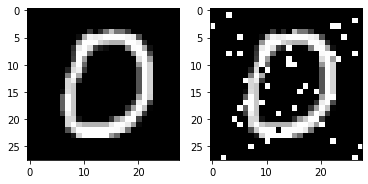

In [17]:
img = test_images[10,].reshape((28, 28))

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(perturbation.salt_pepper_noise(img, p=0.1), cmap="gray")

In [18]:
test_images[0,].shape

(28, 28, 1)

In [32]:
arch = "mlp/e1:1024|e2:1024|z:2"

strategies = [
    "oneshot",
    "algo1/d:5|e:1",
    "algo1/d:10|e:1",
    "algo1/d:20|e:1",
    "algo2/k:5",
    "algo2/k:10",
    "algo2/k:20"
]

M = [1, 6, 12]

# VDB

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9760 -> 0.9760
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9690 -> 0.9730
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9680 -> 0.9680
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--1
 acc: 0.9650 -> 0.9650
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--6
 acc: 0.9720 -> 0.9720
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--12
 acc: 0.9820 -> 0.9820
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:10|e:1--1
 acc: 0.9810 -> 0.9800
Taking nets.ml

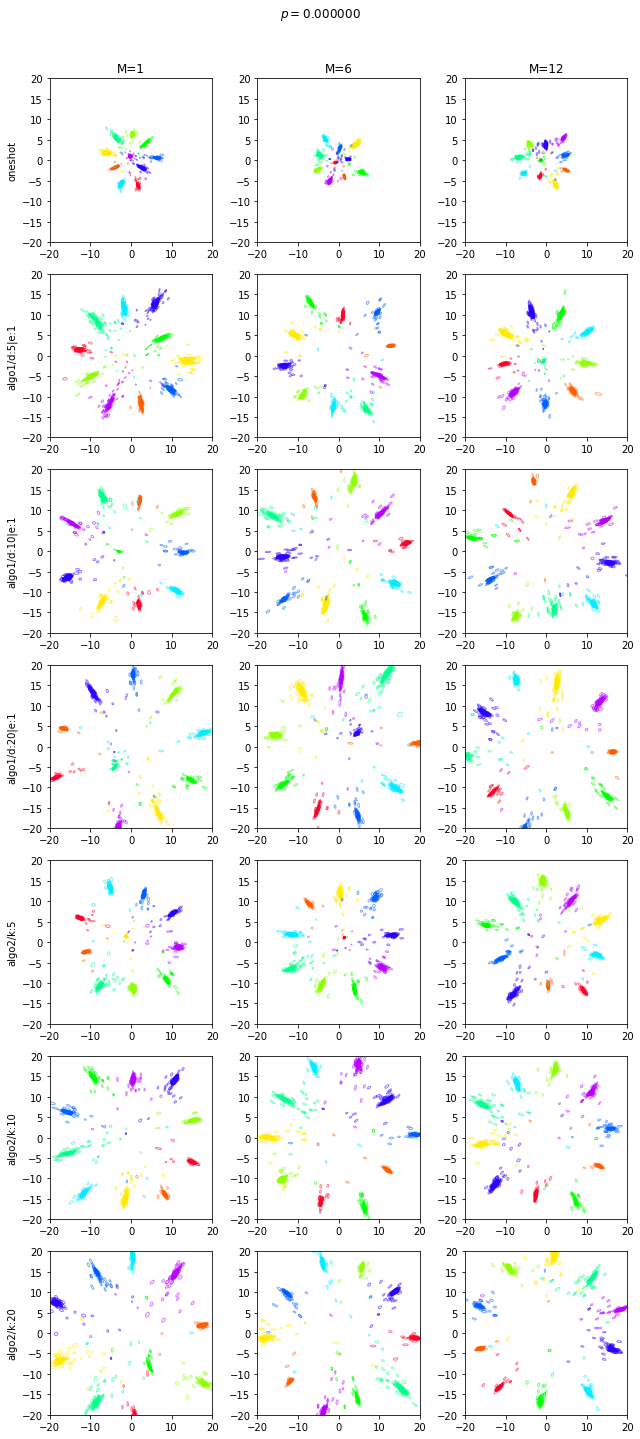

In [33]:
def plot(ax, mu, cov, labels, cm=plt.get_cmap('gist_rainbow')):
    for i in range(10):
        ix = np.argwhere(labels == i)
        ix = ix.reshape(-1)
        plt.scatter(mu[ix, 0], mu[ix, 1], color=cm(i/10), alpha=0.0, label=i)

        for j in range(ix.shape[0]):
            ij = ix[j]
            plot_helper.plot_ellipse(ax, mu[ij,:], cov[ij, :, :], edgecolor=cm(i/10))

    plt.ylim([-20, 20])
    plt.xlim([-20, 20])

def plot_grid(data, arch, strategies, M, p=0.1, L=12):
    total_strategies = len(strategies)
    total_M = len(M)
    
    dataset = data[list(data.keys())[0]]['dataset']
    _, (test_images, test_labels), (subset_images, subset_labels) = get_dataset(dataset, data_path="../datasets")

    extreme_values = np.min(test_images), np.max(test_images)
    subset_images_salt_paper = perturbation.salt_pepper_noise(subset_images, p=p, extreme_values=extreme_values)
    

    plt.figure(figsize=(3*total_M, 3*total_strategies))
    for i, s in enumerate(strategies):
        for j, m in enumerate(M):
            ax = plt.subplot(total_strategies, total_M, i*total_M + j+1)
            if i == 0:
                plt.title(f"M={m}")
            if j == 0:
                plt.ylabel(s)
                
            # load model, add noise, plot
            key = f"{arch}--{s}--{m}"
            path = data[key]['path']

            model, _ = load_model(path)
            print("=======")
            print(key)
#             print(path)
            print(" acc: %.4f -> %.4f" % 
                  (
                      model.compute_acc(subset_images, subset_labels, L).numpy(),
                      model.compute_acc(subset_images_salt_paper, subset_labels, L).numpy(),
                  )
            )
            
            if p > 0:
                latent, _ = model(subset_images_salt_paper)
            else:
                latent, _ = model(subset_images)


            mu = latent.loc.numpy()
            cov = latent.covariance().numpy()
            
            plot(ax, mu, cov, subset_labels)
            
    plt.suptitle("$p=%f$" % p)

    plt.tight_layout( rect=[0, 0.03, 1, 0.95])

    plt.savefig("./figures/2d-latent-salt-pepper-p%d.png" % (p*10))
plot_grid(data, arch, strategies, M, p=0.0)

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9760 -> 0.9540
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9730 -> 0.9390
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9680 -> 0.9610
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--1
 acc: 0.9650 -> 0.9440
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--6
 acc: 0.9730 -> 0.9490
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--12
 acc: 0.9820 -> 0.9620
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:10|e:1--1
 acc: 0.9800 -> 0.9610
Taking nets.ml

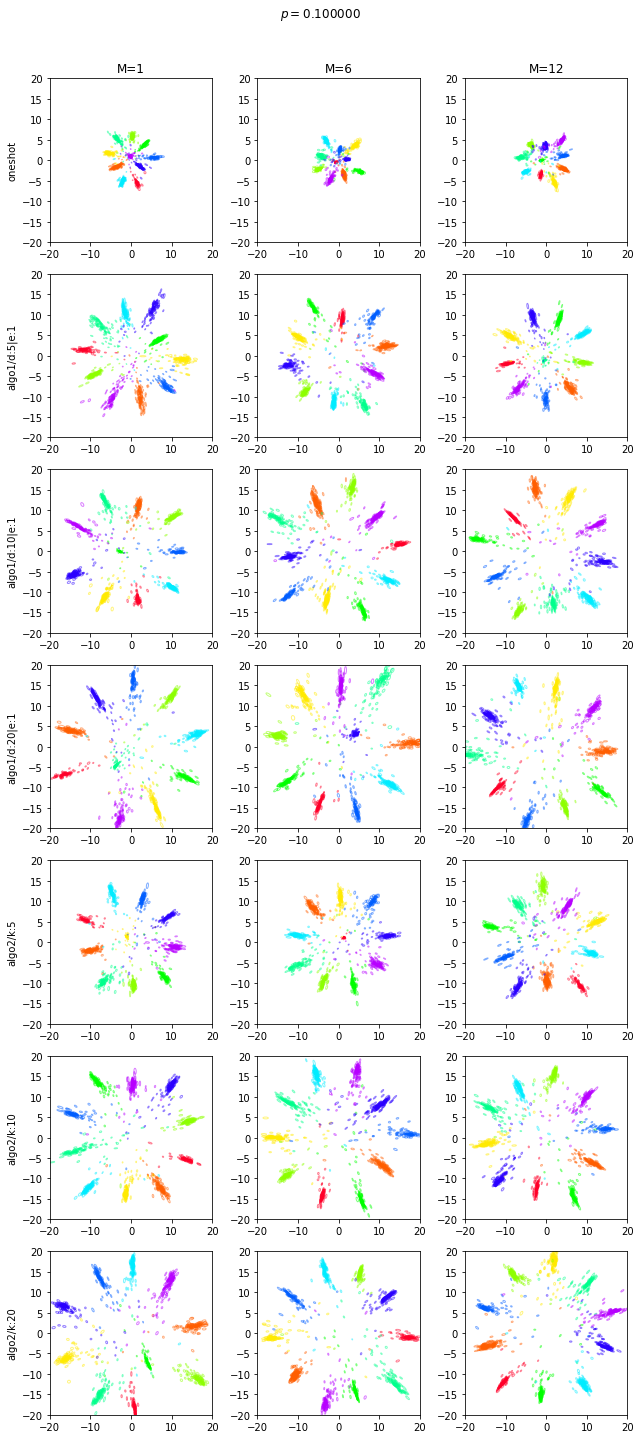

In [34]:
plot_grid(data, arch, strategies, M, p=0.1)

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9760 -> 0.9090
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9720 -> 0.8560
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9690 -> 0.8930
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--1
 acc: 0.9640 -> 0.8950
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--6
 acc: 0.9720 -> 0.8980
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--12
 acc: 0.9820 -> 0.9160
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:10|e:1--1
 acc: 0.9800 -> 0.9100
Taking nets.ml

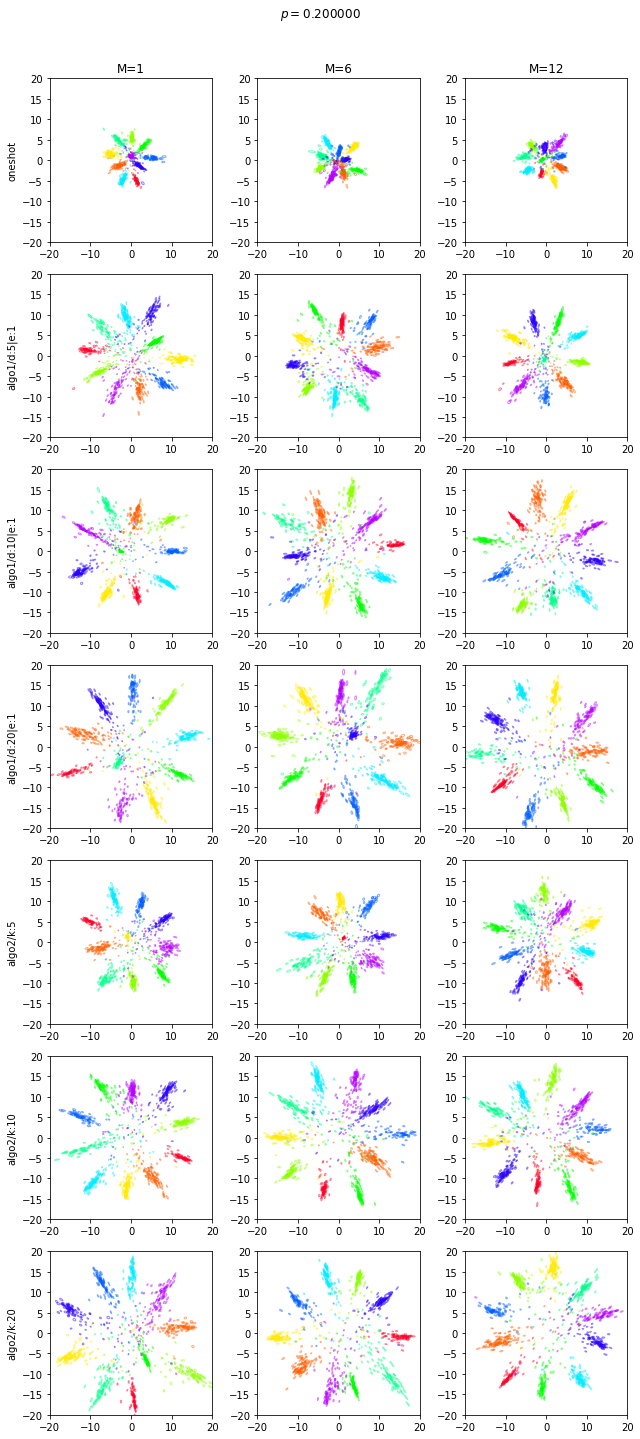

In [35]:
plot_grid(data, arch, strategies, M, p=0.2)

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9760 -> 0.5760
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9700 -> 0.4340
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9690 -> 0.5380
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--1
 acc: 0.9650 -> 0.6550
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--6
 acc: 0.9720 -> 0.6520
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--12
 acc: 0.9830 -> 0.6490
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:10|e:1--1
 acc: 0.9800 -> 0.6260
Taking nets.ml

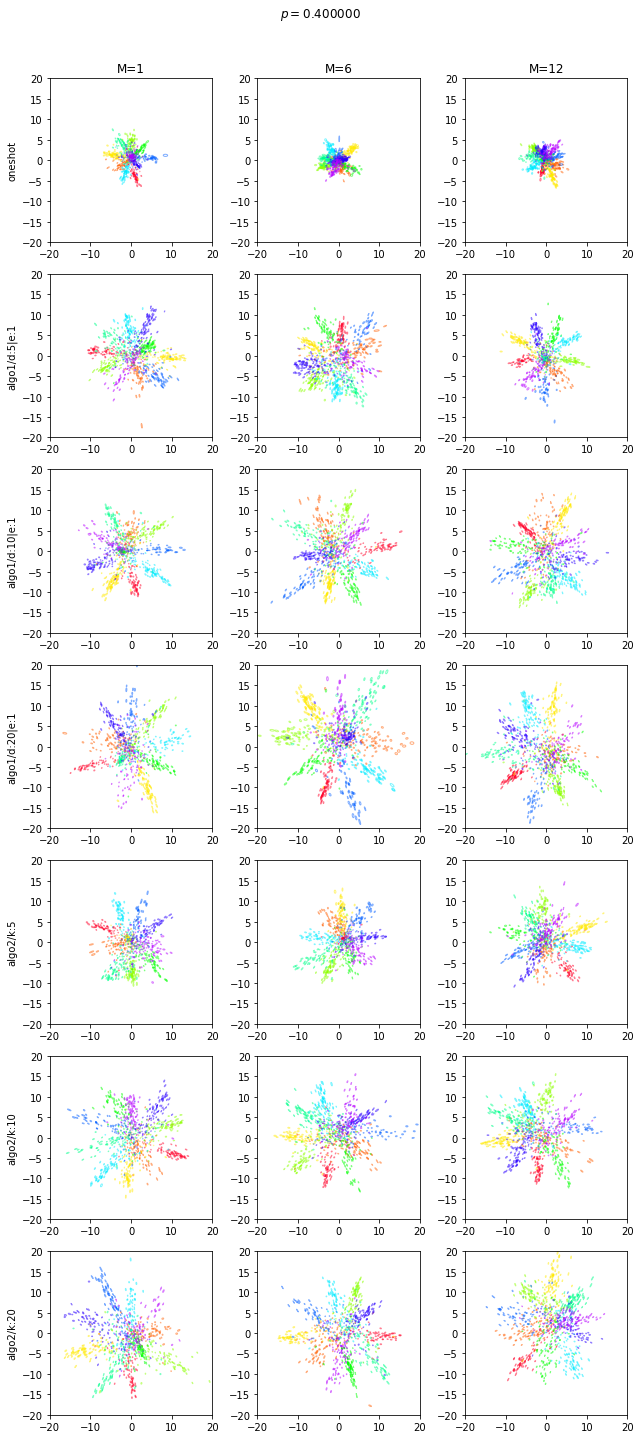

In [36]:
plot_grid(data, arch, strategies, M, p=0.4)

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9760 -> 0.4080
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9720 -> 0.2900
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9680 -> 0.3520
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--1
 acc: 0.9650 -> 0.5020
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--6
 acc: 0.9730 -> 0.4790
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:5|e:1--12
 acc: 0.9820 -> 0.5010
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--algo1/d:10|e:1--1
 acc: 0.9800 -> 0.4740
Taking nets.ml

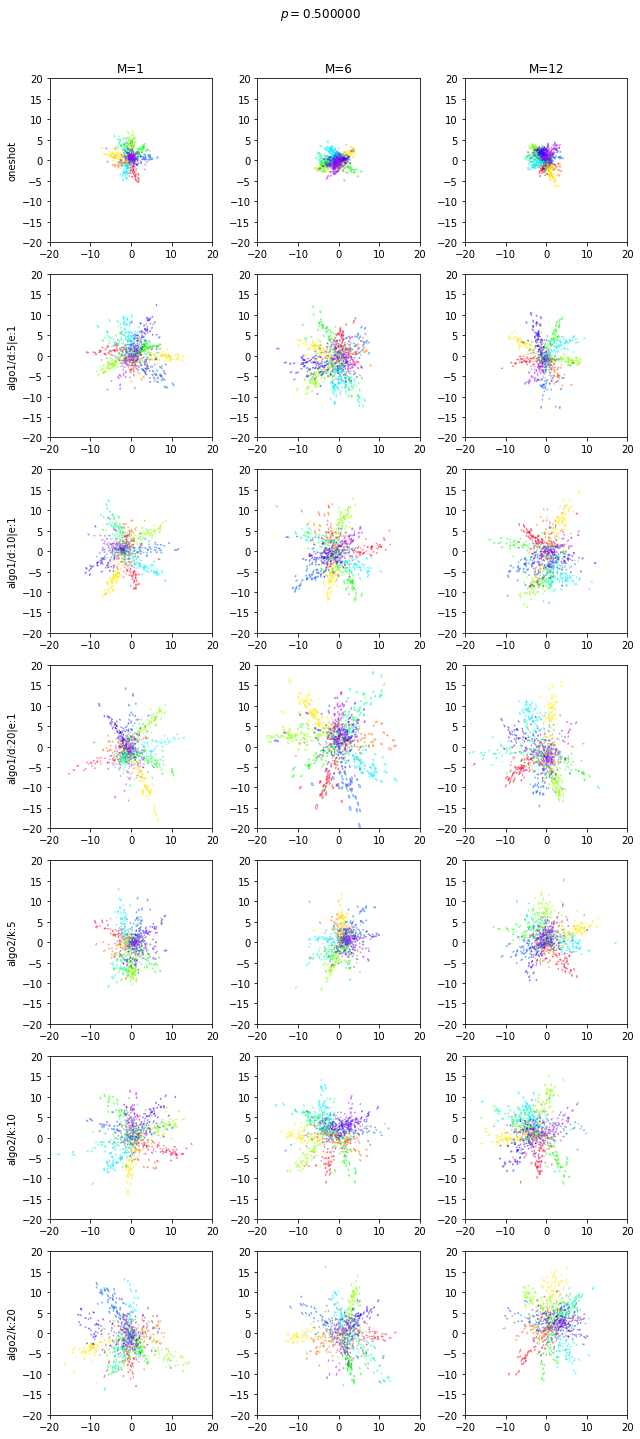

In [37]:
plot_grid(data, arch, strategies, M, p=0.5)

# VIB

In [39]:
data_vib = glob_grid_experiments("../artifacts-server/hydra/experiment-mnist-2d-test-robustness-vib")

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9800 -> 0.9800
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9740 -> 0.9750


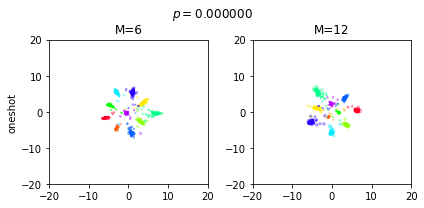

In [41]:
plot_grid(data_vib, arch, ["oneshot"], [6, 12], p=0.0)

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9800 -> 0.9520
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9750 -> 0.9460


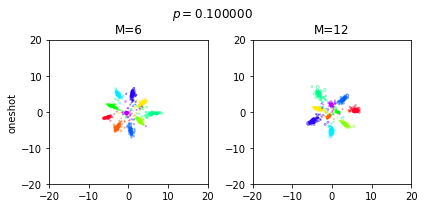

In [42]:
plot_grid(data_vib, arch, ["oneshot"], [6, 12], p=0.1)

Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9800 -> 0.5510
Taking nets.mlp
Using full covariance
Latent dims: 2
Parameters for latent: 5
mlp/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9750 -> 0.5320


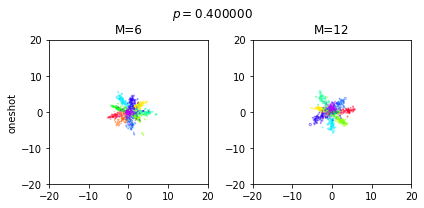

In [43]:
plot_grid(data_vib, arch, ["oneshot"], [6, 12], p=0.4)